In [2]:
from utils import *

class MDP:

    def __init__(self, init, actlist, terminals, gamma=.9):
        update(self, init=init, actlist=actlist, terminals=terminals,
               gamma=gamma, states=set(), reward={})

    def R(self, state):
        return self.reward[state]

    def T(state, action):
        abstract

    def actions(self, state):
        if state in self.terminals:
            return [None]
        else:
            return self.actlist

class GridMDP(MDP):

    def __init__(self, grid, terminals, init=(0, 0), gamma=.9):
        grid.reverse() ## because we want row 0 on bottom, not on top
        MDP.__init__(self, init, actlist=orientations,
                     terminals=terminals, gamma=gamma)
        update(self, grid=grid, rows=len(grid), cols=len(grid[0]))
        for x in range(self.cols):
            for y in range(self.rows):
                self.reward[x, y] = grid[y][x]
                if grid[y][x] is not None:
                    self.states.add((x, y))

    def T(self, state, action):
        if action == None:
            return [(0.0, state)]
        else:
            return [(0.8, self.go(state, action)),
                    (0.1, self.go(state, turn_right(action))),
                    (0.1, self.go(state, turn_left(action)))]

    def go(self, state, direction):
        state1 = vector_add(state, direction)
        return if_(state1 in self.states, state1, state)

    def to_grid(self, mapping):
        return list(reversed([[mapping.get((x,y), None)
                               for x in range(self.cols)]
                              for y in range(self.rows)]))

    def to_arrows(self, policy):
        chars = {(1, 0):'>', (0, 1):'^', (-1, 0):'<', (0, -1):'v', None: '.'}
        return self.to_grid(dict([(s, chars[a]) for (s, a) in policy.items()]))

def value_iteration(mdp, epsilon=0.001):
    
    U1 = dict([(s, 0) for s in mdp.states])
    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    while True:
        U = U1.copy()
        delta = 0
        for s in mdp.states:
            U1[s] = R(s) + gamma * max([sum([p * U[s1] for (p, s1) in T(s, a)])
                                        for a in mdp.actions(s)])
            delta = max(delta, abs(U1[s] - U[s]))
        if delta < epsilon * (1 - gamma) / gamma:
             return U

def best_policy(mdp, U):

    pi = {}
    for s in mdp.states:
        pi[s] = argmax(mdp.actions(s), lambda a:expected_utility(a, s, U, mdp))
    return pi

def expected_utility(a, s, U, mdp):

    return sum([p * U[s1] for (p, s1) in mdp.T(s, a)])

def policy_iteration(mdp):

    U = dict([(s, 0) for s in mdp.states])
    pi = dict([(s, random.choice(mdp.actions(s))) for s in mdp.states])
    while True:
        U = policy_evaluation(pi, U, mdp)
        unchanged = True
        for s in mdp.states:
            a = argmax(mdp.actions(s), lambda a: expected_utility(a,s,U,mdp))
            if a != pi[s]:
                pi[s] = a
                unchanged = False
        if unchanged:
            return pi

def policy_evaluation(pi, U, mdp, k=20):

    R, T, gamma = mdp.R, mdp.T, mdp.gamma
    for i in range(k):
        for s in mdp.states:
            U[s] = R(s) + gamma * sum([p * U[s] for (p, s1) in T(s, pi[s])])
    return U

orientations = [(1,0), (0, 1), (-1, 0), (0, -1)]

In [3]:
grid_mdp_1 = GridMDP([[-0.04, -0.04, -0.04, +1],
                     [-0.04, None,  -0.04, -1],
                     [-0.04, -0.04, -0.04, -0.04]],
                    terminals=[(3, 2), (3, 1)])

In [4]:
value_iteration(grid_mdp_1)

{(0, 0): 0.2962883154554812,
 (0, 1): 0.3984432178350045,
 (0, 2): 0.5093943765842497,
 (1, 0): 0.25386699846479516,
 (1, 2): 0.649585681261095,
 (2, 0): 0.3447542300124158,
 (2, 1): 0.48644001739269643,
 (2, 2): 0.7953620878466678,
 (3, 0): 0.12987274656746342,
 (3, 1): -1.0,
 (3, 2): 1.0}

In [5]:
grid_mdp_1.to_arrows(best_policy(grid_mdp_1, value_iteration(grid_mdp_1)))

[['>', '>', '>', '.'], ['^', None, '^', '.'], ['^', '>', '^', '<']]

[[ 0.29628832  0.253867    0.34475423  0.12987275]
 [ 0.39844322  0.64958568  0.48644002 -1.        ]
 [ 0.50939438  0.64958568  0.79536209  1.        ]]


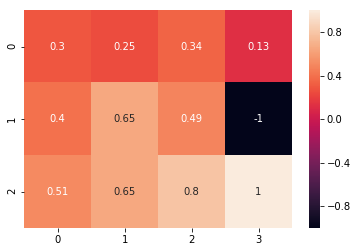

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

vi_utility_dict = value_iteration(grid_mdp_1)
vi_utility_array = np.ndarray((3,4))

for key,value in vi_utility_dict.items():
    vi_utility_array[key[1],key[0]] = value

print(vi_utility_array)

utility_array_df = pd.DataFrame(vi_utility_array)

sns.heatmap(utility_array_df, annot=True)